## Normal VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Gaussian base distribution with Identity Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.05 * \mathbf{1_{n} 1_{n}^\top} +  0.01 * \mathbf{I_{n}}
$$

In this example simulate three fixed effects under the Linear Mixed model with $\beta \sim$ rand(Uniform(-2, 2), p) where p = 3 fixed effects.

max_iter = 100, tol = 10^-8, accept_after_max_steps = 3, limited_memory_max_history = 50

We run each scenario 100 times and compare the fit of ours with that of LMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-2, 2), p)
θtrue = [0.05]
τtrue = [100]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_normal$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_normal$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_normal$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.086126252
 0.076037352
 0.106579129
 0.130311678
 0.102222478
 0.09847342
 0.095267011
 0.097579623
 0.087982559
 0.106301878
 0.109529009
 0.083075082
 0.07886624
 ⋮
 0.653653044
 0.522820911
 0.740375038
 0.553606563
 0.772186938
 0.591039795
 0.591187523
 0.512722793
 0.655824927
 0.561704685
 0.517780395
 0.493739068

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_normal$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
 0.194635983
 0.000461594
 0.000392975
 0.000410191
 0.000378529
 0.000359016
 0.000367197
 0.000354512
 0.00036435
 0.000366655
 0.000362756
 0.000356154
 0.000359099
 ⋮
 0.052172288
 0.051187045
 0.05122641
 0.051096016
 0.054060445
 0.051060742
 0.051780859
 0.050786163
 0.051328232
 0.050525512
 0.051237804
 0.050811935

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.138016,0.0106863,200,0.12733,0.159389,0.000690082
2,100,5,0.163005,0.0336769,500,0.129328,0.230358,0.000326009
3,100,10,0.126576,0.00416532,1000,0.122411,0.134907,0.000126576
4,100,15,0.186335,0.0335545,1500,0.15278,0.253444,0.000124223
5,100,20,0.266044,0.0323188,2000,0.233725,0.330681,0.000133022
6,100,25,0.37809,0.0617742,2500,0.316316,0.501638,0.000151236
7,1000,2,0.133057,0.00573659,2000,0.127321,0.144531,6.65287e-5
8,1000,5,0.132838,0.00682488,5000,0.126013,0.146488,2.65676e-5
9,1000,10,0.126439,0.00214079,10000,0.124298,0.130721,1.26439e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax
,String,String,Float64,Float64,Int64,Float64,Float64
1,100,2,0.00245756,0.00194167,200,0.000515888,0.00439922
2,100,5,0.000632953,5.44843e-5,500,0.000578468,0.000687437
3,100,10,0.000551068,2.25686e-5,1000,0.0005285,0.000573637
4,100,15,0.00062641,2.6203e-5,1500,0.000600207,0.000652613
5,100,20,0.0011398,7.97966e-5,2000,0.00106,0.0012196
6,100,25,0.00180474,0.00093007,2500,0.000874673,0.00273481
7,1000,2,0.00272123,0.00103244,2000,0.00168879,0.00375368
8,1000,5,0.00259899,0.000172516,5000,0.00242648,0.00277151
9,1000,10,0.00300204,7.84534e-6,10000,0.00299419,0.00300989


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


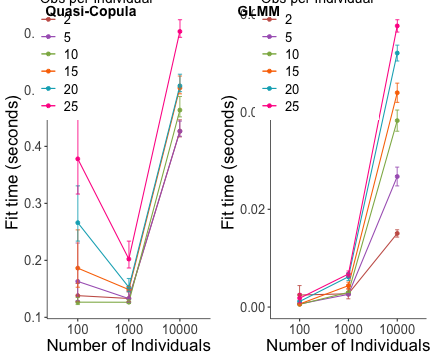

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
    ggsave('sim_lmm_fittime_nsamples_normal_vs_lmm_tau_100_sigma_0.05.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_lmm_fittime_nsamples_normal_vs_lmm_tau_100_sigma_0.05.png"


In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθτcoverage = readdlm("beta_sigma_tau_coverage_normal$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθτcoverage)), :auto)[!, 1:5]
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]; ["τ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]; "τ"])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,θ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.54, 0.0500908)","(0.61, 0.0490207)","(0.55, 0.05)","(0.0, 0.0)"
2,N: 100 ni: 5,"(0.49, 0.0502418)","(0.81, 0.0394277)","(0.67, 0.0472582)","(0.0, 0.0)"
3,N: 100 ni: 10,"(0.5, 0.0502519)","(0.91, 0.0287623)","(0.83, 0.0377525)","(0.0, 0.0)"
4,N: 100 ni: 15,"(0.46, 0.0500908)","(0.89, 0.0314466)","(0.83, 0.0377525)","(0.0, 0.0)"
5,N: 100 ni: 20,"(0.55, 0.05)","(0.83, 0.0377525)","(0.81, 0.0394277)","(0.0, 0.0)"
6,N: 100 ni: 25,"(0.43, 0.049757)","(0.91, 0.0287623)","(0.86, 0.0348735)","(0.0, 0.0)"
7,N: 1000 ni: 2,"(0.48, 0.0502117)","(0.7, 0.0460566)","(0.64, 0.0482418)","(0.0, 0.0)"
8,N: 1000 ni: 5,"(0.43, 0.049757)","(0.81, 0.0394277)","(0.84, 0.0368453)","(0.0, 0.0)"
9,N: 1000 ni: 10,"(0.49, 0.0502418)","(0.87, 0.0337998)","(0.86, 0.0348735)","(0.0, 0.0)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_normal$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_normal$(nsims)reps_sim.csv", ','))
τMseresult = vec(readdlm("mse_tau_multivariate_normal$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_normal$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_normal$(nsims)reps_sim.csv", ','))
τMseresult_GLMM = vec(readdlm("mse_tau_GLMM_normal$(nsims)reps_sim.csv", ','))

p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, τmse = τMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, τmse = τMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
        "taumse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
        "taumse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf1[!, :taumse]; msedf2[!, :betamse]; msedf2[!, :thetamse]; msedf2[!, :taumse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :theta, :tau]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta, :tau]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Gaussian QC"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Gaussian LMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.000312907,2,100,beta,Gaussian QC
2,0.000509746,2,100,beta,Gaussian QC
3,2.27896e-5,2,100,beta,Gaussian QC
4,0.000465848,2,100,beta,Gaussian QC
5,7.77977e-5,2,100,beta,Gaussian QC
6,0.000269171,2,100,beta,Gaussian QC
7,0.000168307,2,100,beta,Gaussian QC
8,0.000326731,2,100,beta,Gaussian QC
9,4.08434e-5,2,100,beta,Gaussian QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


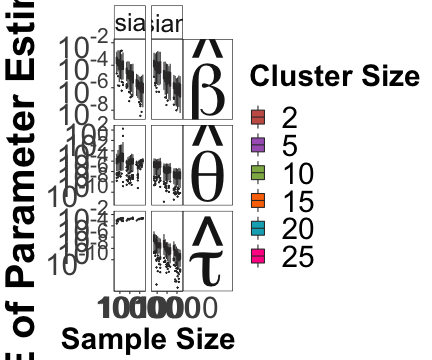

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "tau",y_min := 10^-10]
msedfR[parameters == "tau",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'tau'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), tau = expression(hat(bold(tau)))))
msedfR$robust <- factor(msedfR$robust, levels = c('Gaussian QC', 'Gaussian LMM'),
    labels = c(expression(paste("Gaussian QC")), expression(paste("Gaussian LMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [13]:
R"""
    ggsave('sim_lmm_updated_msefacetplot_normal_0.05_tau_100.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_lmm_updated_msefacetplot_normal_0.05_tau_100.png"
